## Configurando o Ambiente de Análise

In [1]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


pd.set_option("display.max_colwidth", None)
sns.set_theme(style="ticks", context="notebook", font_scale=1.2)
plt.rcParams.update({
    "figure.figsize": (12,6), 
    "axes.spines.top": False, 
    "axes.spines.right": False
})

## Carregando os Dados

In [2]:
path_airlines = "../../datalake/stage/airlines.csv"
path_airports = "../../datalake/stage/airports.csv"
path_flights = "../../datalake/stage/flights.csv"

airlines_df = pd.read_csv(path_airlines, low_memory=False, encoding="utf-8")
airports_df = pd.read_csv(path_airports, low_memory=False, encoding="utf-8")
flights_df = pd.read_csv(path_flights, low_memory=False, encoding="utf-8")

print(f"Dados de companhias aéreas carregados carregados com: {len(airlines_df):,} tuplas × {airlines_df.shape[1]} colunas")
print(f"Dados de aeroportos carregados com: {len(airports_df):,} tuplas × {airports_df.shape[1]} colunas")
print(f"Dados de voos carregados com: {len(flights_df):,} tuplas × {flights_df.shape[1]} colunas")

Dados de companhias aéreas carregados carregados com: 14 tuplas × 2 colunas
Dados de aeroportos carregados com: 322 tuplas × 7 colunas
Dados de voos carregados com: 5,819,079 tuplas × 31 colunas


## Introdução

Este notebook apresenta a Análise Exploratória de Dados (EDA) sobre o conjunto de dados de voos nos Estados Unidos, disponibilizado pelo U.S. Department of Transportation. O objetivo é identificar padrões, inconsistências e oportunidades de melhoria na qualidade dos dados brutos (camada bronze), a fim de apoiar a criação de regras de limpeza e transformação para a camada silver.

A análise é conduzida sob a ótica da Engenharia de Dados, e tem como principal finalidade:

- Diagnosticar a qualidade dos dados na camada bronze;
- Apoiar a definição das regras de limpeza e padronização para a camada silver;
- Identificar padrões e anomalias que possam impactar os relatórios de desempenho de voos.

Cada etapa do EDA é acompanhada de explicações técnicas e recomendações para tratamento futuro.

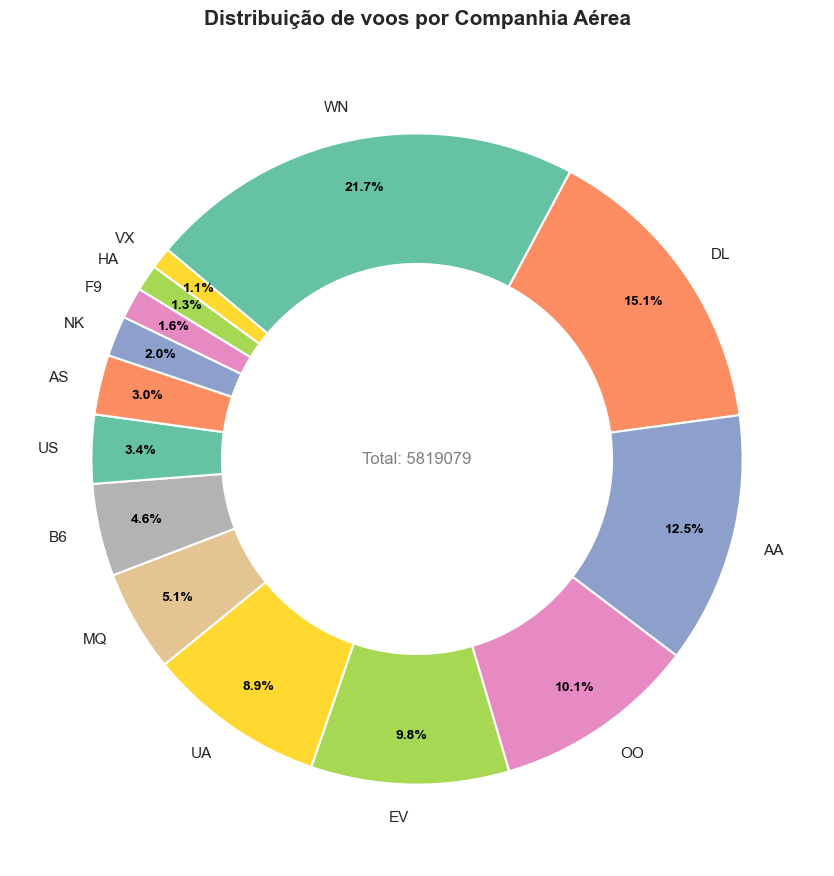

In [3]:
# Distribuição de voos por companhia aérea
flight_counts = flights_df['AIRLINE'].value_counts().sort_values(ascending=False)

# Paleta e explosão para destaque visual
colors = sns.color_palette("Set2", n_colors=len(flight_counts))
explode = [0.05 if i == 0 else 0.02 for i in range(len(flight_counts))]

fig, ax = plt.subplots(figsize=(9, 9))

wedges, texts, autotexts = ax.pie(
    flight_counts,
    labels=flight_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False,
    colors=colors,
    pctdistance=0.85,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

# Adiciona círculo central para efeito "donut"
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig.gca().add_artist(centre_circle)

# Ajustes visuais
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=11)
plt.title("Distribuição de voos por Companhia Aérea", fontsize=15, pad=20, weight="bold")
ax.text(0, 0, f"Total: {flight_counts.sum()}", ha='center', va='center', fontsize=12, color='gray')

plt.tight_layout()
plt.show()

## Objetivos

1. **Explorar a estrutura dos dados brutos**: tipos, volume, duplicatas e ausências;
2. **Avaliar a consistência interna**: duplicatas naturais, cardinalidade e formatos irregulares;
3. **Diagnosticar potenciais problemas de schema**: tipos incorretos e valores inconsistentes;
4. **Gerar documentação de apoio** para o tratamento dos dados na camada Silver.

## Metodologia

A análise foi estruturada segundo um **fluxo incremental**, seguindo as seguintes etapas:

1. **Inspeção inicial**: Estrutura, dimensões e tipos de dados;
2. **Análise de valores ausentes**: Identificação e quantificação de nulos;
3. **Cardinalidade e duplicatas**: Diagnóstico de unicidade e granularidade;
4. **Verificação de tipos e inconsistências**: Identificação de colunas com tipos inadequados;
5. **Interpretação contextual**: Discussão dos achados, com foco em implicações para a Silver.


## Análise do Dataset de Companhias Aéreas (airlines.csv)

Esse dataset possui apenas **14 tuplas**, ou seja, é uma tabela dimensional de referência, não um dataset transacional (como o flights.csv). Ele serve para mapear códigos **IATA** para nomes de companhias aéreas e será referenciado pelo dataset de voos (flights.csv).

### Inspeção inicial

In [23]:
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [24]:
airlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 356.0+ bytes


O resultado mostra que não existe valores nulos, porém existe uma inconsistências nos dados, apesar de se parecer com **strings**, as colunas são vistas como **object**. Essa é a primeira inconsistência que devemos tratar na silver.

### Verificação de duplicatas

In [26]:
airlines_df.duplicated(subset='IATA_CODE').sum()

np.int64(0)

Pelo resultado não existem valores absolutamente idênticos no dataset. Cada companhia aérea possui um código IATA único, indicando integridade referencial válida, podendo ser utilizada como chaves primárias.

### Verificando as cardinalidades

In [27]:
airlines_df.nunique()

IATA_CODE    14
AIRLINE      14
dtype: int64

O dataset tem comportamento de natureza categórica nominal.

### Verificando coerência semântica

In [28]:
for col in airlines_df.columns:
    print(f"\nColuna: {col}")
    print(airlines_df[col].unique())


Coluna: IATA_CODE
['UA' 'AA' 'US' 'F9' 'B6' 'OO' 'AS' 'NK' 'WN' 'DL' 'EV' 'HA' 'MQ' 'VX']

Coluna: AIRLINE
['United Air Lines Inc.' 'American Airlines Inc.' 'US Airways Inc.'
 'Frontier Airlines Inc.' 'JetBlue Airways' 'Skywest Airlines Inc.'
 'Alaska Airlines Inc.' 'Spirit Air Lines' 'Southwest Airlines Co.'
 'Delta Air Lines Inc.' 'Atlantic Southeast Airlines'
 'Hawaiian Airlines Inc.' 'American Eagle Airlines Inc.' 'Virgin America']


### Verificação de integridade referencial (com flights.csv)

In [29]:
missing_codes = set(flights_df["AIRLINE"].unique()) - set(airlines_df["IATA_CODE"].unique())
missing_codes

set()

Set vazio. Todas as companhias referenciadas em *flights* têm correspondência válida em *airlines*.

### Plano de Ação - Diretrizes para a camada Silver

**Airline**
  - Alterar tipo da coluna IATA_CODE: *object* -> *string*;
  - Alterar tipo da coluna AIRLINE: *object* -> *string*;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRLINE_IATA_CODE*;
  - Tornar a coluna AIRLINE_IATA_CODE 'primary key'.

**Airports**

**Flights**

## Análise do Dataset de Aeroportos (airports.csv)

### Inspeção Inicial

In [46]:
print("Dimensões (linhas, colunas):", airports_df.shape)

Dimensões (linhas, colunas): (322, 7)


In [19]:
display(airports_df.head())

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [64]:
airports_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 100.4 KB


In [20]:
airports_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IATA_CODE,322,322,ABE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AIRPORT,322,322,Lehigh Valley International Airport,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CITY,322,308,Jackson,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATE,322,54,TX,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COUNTRY,322,1,USA,322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LATITUDE,319.0,NaN,NaN,NaN,38.981244,8.616736,13.48345,33.65204,39.29761,43.154675,71.28545
LONGITUDE,319.0,NaN,NaN,NaN,-98.378964,21.523492,-176.64603,-110.839385,-93.40307,-82.722995,-64.79856


Os resultados mostram que existem colunas com inconsistências nos seus tipos e que existem dados faltando em duas colunas.

### Análise de Valores Ausentes

In [22]:
# Investigar mais a fundo os dados faltosos.
null_counts = airports_df.isna().sum()
null_pct = (null_counts / len(airports_df)).mul(100).round(3)
null_summary = pd.concat([null_counts.rename("n_missing"), null_pct.rename("%_missing")], axis=1).sort_values("%_missing", ascending=False)
null_summary

,n_missing,%_missing
LATITUDE,3,0.932
LONGITUDE,3,0.932
IATA_CODE,0,0.000
AIRPORT,0,0.000
CITY,0,0.000
STATE,0,0.000
COUNTRY,0,0.000


Três valores faltantes nas colunas **"LATITUDE"** e **"LONGITUDE"**. Ponto a ser tratado para a silver.

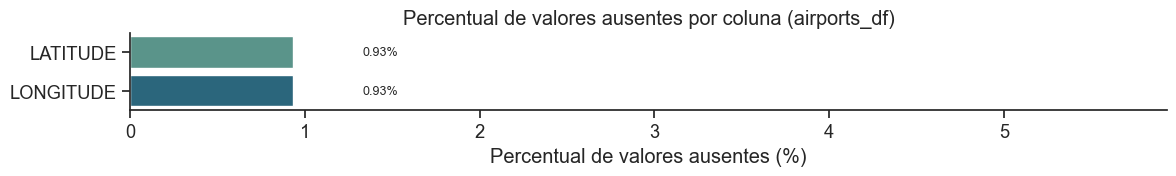

In [24]:
# Só colunas com >0% de nulos para visibilidade
plot_df = null_summary[null_summary["%_missing"] > 0].reset_index().rename(columns={"index":"coluna"})

if not plot_df.empty:
    fig, ax = plt.subplots(figsize=(12, 0.5 * max(4, len(plot_df))))
    sns.barplot(data=plot_df, x="%_missing", y="coluna", hue="coluna", palette="crest", dodge=False, ax=ax, legend=False)
    for i, v in enumerate(plot_df["%_missing"]):
        ax.text(v + 0.4, i, f"{v:.2f}%", va="center", fontsize=9)
    ax.set_xlabel("Percentual de valores ausentes (%)")
    ax.set_ylabel("")
    ax.set_xlim(0, plot_df["%_missing"].max() + 5)
    plt.title("")
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma coluna com valores ausentes.")

### Cardinalidade e Duplicatas

In [25]:
# Checagem de duplicidade pela chave natural
dup_iata = airports_df[airports_df.duplicated(subset=['IATA_CODE'], keep=False)]
print(f"Número de duplicatas pela chave IATA_CODE: {dup_iata.shape[0]}")

Número de duplicatas pela chave IATA_CODE: 0


In [26]:
# Verificação de duplicatas completas
dup_full = airports_df[airports_df.duplicated()]
print(f"Número de tuplas completamente duplicadas: {dup_full.shape[0]}")

Número de linhas completamente duplicadas: 0


In [27]:
# Verifica todas as colunas
for col in airports_df.columns:
    dup_count = airports_df.duplicated(subset=[col]).sum()
    print(f"{col}: {dup_count} duplicatas")

IATA_CODE: 0 duplicatas
AIRPORT: 0 duplicatas
CITY: 14 duplicatas
STATE: 268 duplicatas
COUNTRY: 321 duplicatas
LATITUDE: 2 duplicatas
LONGITUDE: 2 duplicatas


Os resultados mostram quase o esperado, nenhum valor duplicado no IATA_CODE e AIRPORT, e algumas duplicatas para as outras colunas. Porém, as colunas de coordenadas possuem 2 duplicatas e não 3 como esperado, isso pode ser justificado pelo fato do pandas tratar o 'NaN' como "valor" e os outros 'NaN' como repetição, mas vamos investigar melhor.

In [19]:
print(f"Tuplas com nuloss\n")
display(airports_df[airports_df[['LATITUDE', 'LONGITUDE']].isnull().any(axis=1)])
print(f"Tuplas com duplicatas nos nuloss\n")
display(airports_df[airports_df.duplicated(subset=['LATITUDE'])])

Tuplas com nuloss



,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. Augustine Airport),St. Augustine,FL,USA,NaN,NaN


Tuplas com duplicatas nos nuloss



,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. Augustine Airport),St. Augustine,FL,USA,NaN,NaN


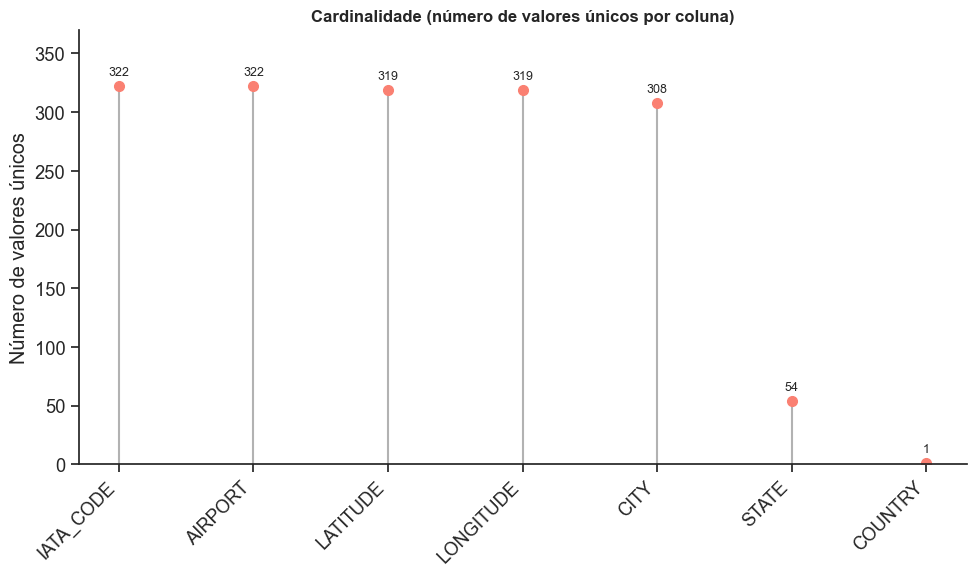

In [39]:
cardinality = (
    airports_df.nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'index': 'coluna', 0: 'n_unique'})
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.vlines(
    x=cardinality["coluna"],
    ymin=0, ymax=cardinality["n_unique"],
    color="gray", alpha=0.6, linewidth=1.5
)
ax.plot(
    cardinality["coluna"], cardinality["n_unique"],
    "o", markersize=7, color="salmon"
)

for i, v in enumerate(cardinality["n_unique"]):
    ax.text(
        i, v + max(cardinality["n_unique"]) * 0.02,
        f"{v}", ha="center", va="bottom", fontsize=9
    )

# Estética e formatação
ax.set_title("Cardinalidade (número de valores únicos por coluna)", fontsize=12, weight="bold")
ax.set_ylabel("Número de valores únicos")
ax.set_xlabel("")
ax.set_ylim(0, cardinality["n_unique"].max() * 1.15)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Verificação de Tipos e Inconsistências

In [44]:
# Colunas que deveriam conter apenas texto
text_cols = ['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY']

for col in text_cols:
    non_text = airports_df[~airports_df[col].astype(str).str.match(r'^[A-Za-zÀ-ÿ\s\-\.\']+$', na=False)]
    
    if not non_text.empty:
        print(f"\nColuna '{col}' possui valores suspeitos (não textuais):")
        print(f"Total de tuplas afetadas: {len(non_text)}")
        display(non_text[col])
    else:
        print(f"\nColuna '{col}' sem valores suspeitos.")


✅ Coluna 'IATA_CODE' sem valores suspeitos.

⚠️ Coluna 'AIRPORT' possui valores suspeitos (não textuais):
→ Total de tuplas afetadas: 51


12                                             Augusta Regional Airport (Bush Field)
24                                       Wilkes-Barre/Scranton International Airport
25                                      Kalamazoo/Battle Creek International Airport
38                                                Boise Airport (Boise Air Terminal)
40                           Jack Brooks Regional Airport (Southeast Texas Regional)
44                              Brownsville/South Padre Island International Airport
50                                      Bob Hope Airport (Hollywood Burbank Airport)
52                Bozeman Yellowstone International Airport (Gallatin Field Airport)
56                                                  Merle K. (Mudhole) Smith Airport
57                                    Del Norte County Airport (Jack McNamara Field)
58                                   Chattanooga Metropolitan Airport (Lovell Field)
60                                   Charleston International Air


⚠️ Coluna 'CITY' possui valores suspeitos (não textuais):
→ Total de tuplas afetadas: 7


7                       Arcata/Eureka
24              Wilkes-Barre/Scranton
40               Beaumont/Port Arthur
68                   Champaign/Urbana
156           Iron Mountain/Kingsford
170                       Kailua/Kona
319    Fayetteville/Springdale/Rogers
Name: CITY, dtype: object

✅ Coluna 'STATE' sem valores suspeitos.
✅ Coluna 'COUNTRY' sem valores suspeitos.


### Plano de Ação - Diretrizes para a camada Silver

**Airline**
  - Realizar as conversões de tipos de acordo com as regras de negócio;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRLINE_IATA_CODE*;
  - Tornar a coluna AIRLINE_IATA_CODE 'primary key'.

**Airports**
  - Realizar as conversões de tipos de acordo com as regras de negócio;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRPORT_IATA_CODE*;
  - Tornar a coluna AIRPORT_IATA_CODE 'primary key'.
  - Remover coluna COUNTRY;
  - LATITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST;
  - LONGITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST.

**Flights**

## Análise do Dataset de Voos (flights.csv)

### Inspeção inicial

In [9]:
print("Dimensões (linhas, colunas):", flights_df.shape)

Dimensões (linhas, colunas): (5819079, 31)


In [10]:
display(flights_df.head())

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
flights_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [12]:
display(flights_df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
YEAR,5819079.0,NaN,NaN,NaN,2015.0,0.0,2015.0,2015.0,2015.0,2015.0,2015.0
MONTH,5819079.0,NaN,NaN,NaN,6.524085,3.405137,1.0,4.0,7.0,9.0,12.0
DAY,5819079.0,NaN,NaN,NaN,15.704594,8.783425,1.0,8.0,16.0,23.0,31.0
DAY_OF_WEEK,5819079.0,NaN,NaN,NaN,3.926941,1.988845,1.0,2.0,4.0,6.0,7.0
AIRLINE,5819079,14,WN,1261855,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FLIGHT_NUMBER,5819079.0,NaN,NaN,NaN,2173.092742,1757.063999,1.0,730.0,1690.0,3230.0,9855.0
TAIL_NUMBER,5804358,4897,N480HA,3768,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_AIRPORT,5819079,628,ATL,346836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DESTINATION_AIRPORT,5819079,629,ATL,346904,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SCHEDULED_DEPARTURE,5819079.0,NaN,NaN,NaN,1329.60247,483.751821,1.0,917.0,1325.0,1730.0,2359.0


### Filtragem de voos cancelados

Como o foco do projeto é **atrasos em voos realizados**, todas as linhas com `CANCELLED = 1` são removidas, assim como colunas associadas a cancelamentos.

In [15]:
cols = ['CANCELLED', 'CANCELLATION_REASON']

flights_df = flights_df[flights_df['CANCELLED'] != 1].drop(columns=cols)


### Valores ausentes

Vamos verificar o percentual de valores ausentes em cada coluna.

In [16]:
null_counts = flights_df.isna().sum()
null_pct = (null_counts / len(flights_df) * 100).round(2)
null_summary = pd.concat(
    [null_counts.rename("n_missing"), null_pct.rename("%_missing")],
    axis=1
).sort_values("%_missing", ascending=False)
null_summary.head(30)

,n_missing,%_missing
WEATHER_DELAY,4665756,81.44
LATE_AIRCRAFT_DELAY,4665756,81.44
AIRLINE_DELAY,4665756,81.44
SECURITY_DELAY,4665756,81.44
AIR_SYSTEM_DELAY,4665756,81.44
ELAPSED_TIME,15187,0.27
ARRIVAL_DELAY,15187,0.27
AIR_TIME,15187,0.27
ARRIVAL_TIME,2629,0.05
TAXI_IN,2629,0.05


**Foram encontrados valores nulos. Gerando gráfico...**

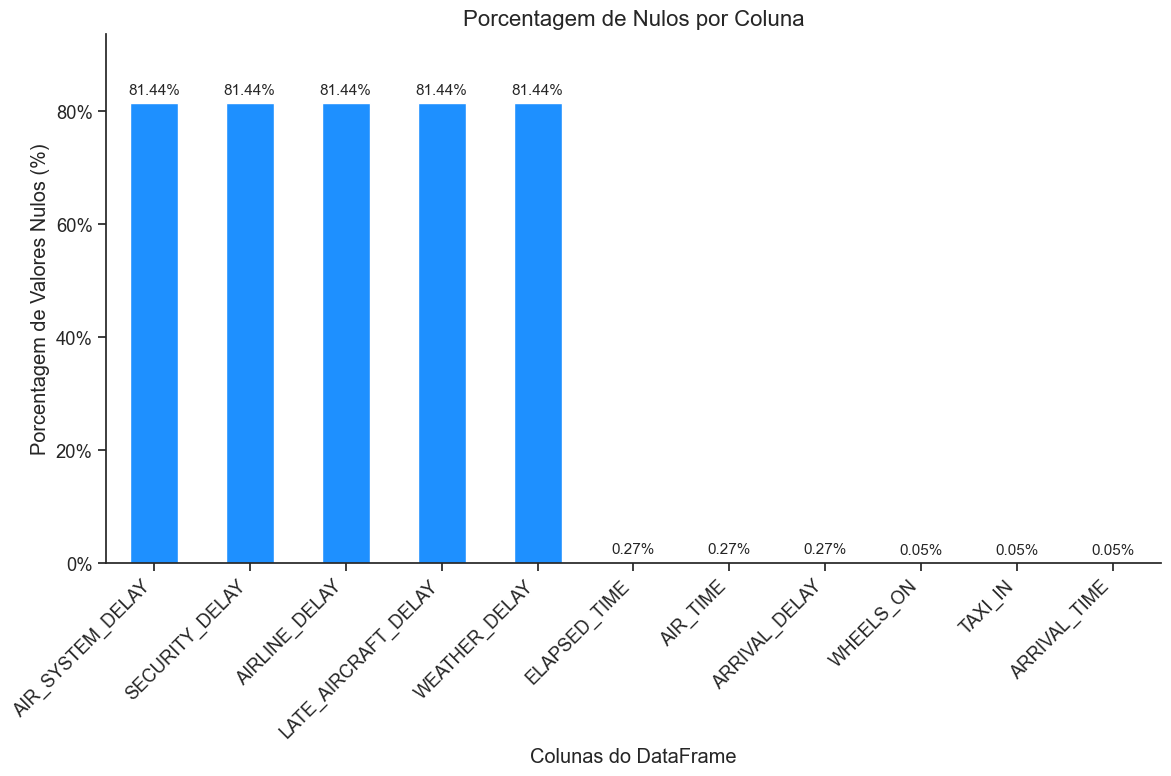

In [17]:
pct_nulos = null_pct[null_pct > 0].sort_values(ascending=False)

if not pct_nulos.empty:
    display(Markdown("**Foram encontrados valores nulos. Gerando gráfico...**"))
    fig, ax = plt.subplots(figsize=(12, 8))
    pct_nulos.plot(kind='bar', color='dodgerblue', ax=ax)

    ax.set_title('Porcentagem de Nulos por Coluna', fontsize=16)
    ax.set_ylabel('Porcentagem de Valores Nulos (%)')
    ax.set_xlabel('Colunas do DataFrame')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points', fontsize=11)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.ylim(0, pct_nulos.max() * 1.15)
    plt.show()
else:
    display(Markdown("**Não foram encontrados valores nulos no conjunto de dados.**"))

#### Investigando valores ausentes nas colunas com final _DELAY

As colunas que terminam com _DELAY têm alta taxa de nulos. Vamos verificar detalhadamente.

In [19]:
delay_cols = [c for c in flights_df.columns if c.endswith("_DELAY")]

delay_null_summary = flights_df[delay_cols].isna().sum().to_frame("n_missing")
delay_null_summary["pct_missing"] = (
    delay_null_summary["n_missing"] / len(flights_df) * 100
).round(2)

display(delay_null_summary)

,n_missing,pct_missing
DEPARTURE_DELAY,0,0.00
ARRIVAL_DELAY,15187,0.27
AIR_SYSTEM_DELAY,4665756,81.44
SECURITY_DELAY,4665756,81.44
AIRLINE_DELAY,4665756,81.44
LATE_AIRCRAFT_DELAY,4665756,81.44
WEATHER_DELAY,4665756,81.44


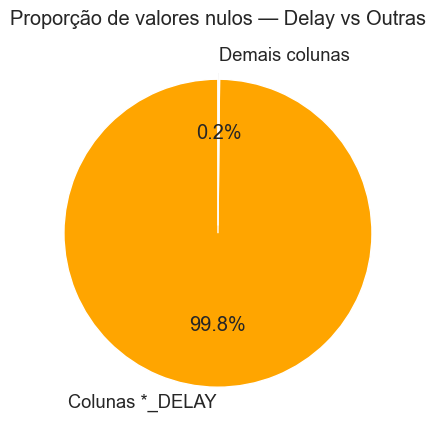

In [20]:
delay_missing = null_summary.loc[delay_cols, "n_missing"].sum()
other_missing = null_summary.loc[~null_summary.index.isin(delay_cols), "n_missing"].sum()

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie([delay_missing, other_missing],
       labels=['Colunas *_DELAY', 'Demais colunas'],
       autopct='%1.1f%%',
       colors=['orange', 'lightgray'],
       startangle=90,
       explode=[0.05, 0])
ax.set_title('Proporção de valores nulos — Delay vs Outras')
plt.show()

Vamos visualizar a relação entre colunas que têm valores ausentes para identificar dependências estruturais.

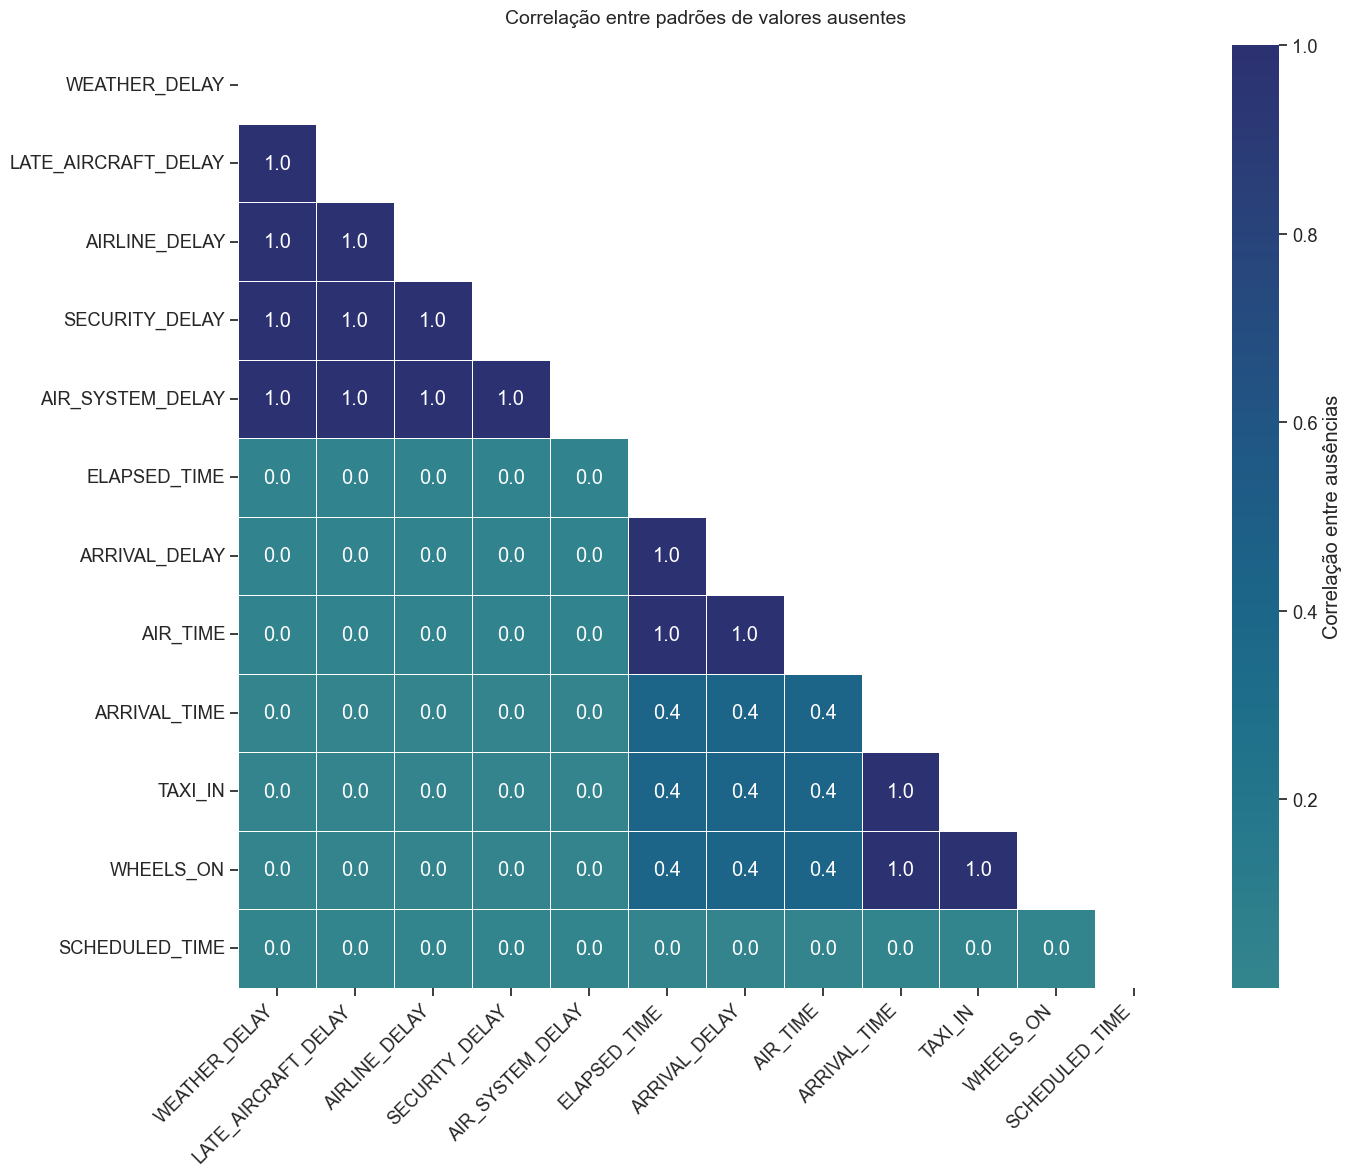

,col_1,col_2,corr
0,WEATHER_DELAY,LATE_AIRCRAFT_DELAY,1.0
1,WEATHER_DELAY,AIRLINE_DELAY,1.0
118,WHEELS_ON,ARRIVAL_TIME,1.0
108,TAXI_IN,WHEELS_ON,1.0
107,TAXI_IN,ARRIVAL_TIME,1.0
97,ARRIVAL_TIME,WHEELS_ON,1.0
96,ARRIVAL_TIME,TAXI_IN,1.0
83,AIR_TIME,ARRIVAL_DELAY,1.0
82,AIR_TIME,ELAPSED_TIME,1.0
72,ARRIVAL_DELAY,AIR_TIME,1.0


In [21]:
cols_with_missing = null_summary[null_summary["n_missing"] > 0].index.tolist()

if cols_with_missing:
    miss_matrix = flights_df[cols_with_missing].isna().astype(int)
    corr = miss_matrix.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(min(1.2*len(corr), 16), min(1.2*len(corr), 12)))
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        cmap="crest",
        center=0,
        cbar_kws={'label': 'Correlação entre ausências'},
        fmt=".1f",
        linewidths=0.5
    )
    plt.title("Correlação entre padrões de valores ausentes", fontsize=14, pad=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    high_corr = (
        corr.where(~np.eye(len(corr), dtype=bool))
        .stack()
        .reset_index()
        .rename(columns={"level_0": "col_1", "level_1": "col_2", 0: "corr"})
        .query("corr > 0.85")
        .sort_values("corr", ascending=False)
    )
    display(high_corr.head(15))
else:
    print("Nenhuma coluna com valores ausentes.")


Esses ~81% de dados faltantes nas colunas de motivo de atraso (_DELAY) pode está ocorrendo porque esses campos só são preenchidos para voos que chegaram atrasados. Vamos verificar se para voos que chegaram no horário ou adiantados, esses campos estão de fato vazios.

In [22]:
on_time_or_early = flights_df[flights_df['ARRIVAL_DELAY'] <= 0]

reason_columns = [
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]

non_null_counts = on_time_or_early[reason_columns].notnull().sum()
print("Contagem de valores preenchidos para voos pontuais:")
print(non_null_counts)

Contagem de valores preenchidos para voos pontuais:
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64


Como de esperado a saída mostra 0 para todas as colunas. Isso confirma que os motivos de atraso só são registrados para voos com ARRIVAL_DELAY > 0, e que os valores nulos são, na verdade, zeros por regras de negócios. Porém, ainda temos os valores da coluna ARRIVAL_DELAY. Um dos motivos que os dados de chegada (ARRIVAL_DELAY, ARRIVAL_TIME, etc.) estão faltando, é porque os voos podem terem sidos desviados (DIVERTED=1) para outros aeroportos. Vamos filtrar todas as linhas com ARRIVAL_DELAY nulo e verificar se a coluna DIVERTED está marcada como 1 (verdadeiro).

In [23]:
missing_arrival_delay = flights_df[flights_df['ARRIVAL_DELAY'].isnull()]
diverted_counts = missing_arrival_delay['DIVERTED'].value_counts()

print("Status de desvio para voos com atraso na chegada nulo:")
print(diverted_counts)

Status de desvio para voos com atraso na chegada nulo:
DIVERTED
1    15187
Name: count, dtype: int64


O resultado confirma a hipótese, os voos com ARRIVAL_DELAY nulos são os desviados.

#### Investigando valores ausentes nas colunas com final _TIME e relacionadas

Antes de aplicar qualquer tratamento, é essencial entender onde há ausências de dados nas colunas relacionadas a horários.

In [24]:
time_cols = [c for c in flights_df.columns if c.endswith("_TIME")]

# Contagem de nulos
time_null_summary = flights_df[time_cols].isna().sum().to_frame("n_missing")
time_null_summary["pct_missing"] = (time_null_summary["n_missing"] / len(flights_df) * 100).round(2)
display(time_null_summary)

,n_missing,pct_missing
DEPARTURE_TIME,0,0.00
SCHEDULED_TIME,1,0.00
ELAPSED_TIME,15187,0.27
AIR_TIME,15187,0.27
ARRIVAL_TIME,2629,0.05


O número de valores nulos para ELAPSED_TIME e AIR_TIME é exatamente o mesmo de ARRIVAL_DELAY. A causa é a mesma que já confirmada, os voos desviados (DIVERTED == 1). O ELAPSED_TIME (tempo total de portão a portão) e o AIR_TIME (tempo no ar) são métricas que dependem da conclusão de um voo. Se o voo foi desviado, essas durações para a rota planejada não são finalizadas e, portanto, não são registradas. Vamos confirmar a relação entre ELAPSED_TIME nulo e DIVERTED

In [25]:
# Filtra onde ELAPSED_TIME é nulo
null_elapsed_time = flights_df[flights_df['ELAPSED_TIME'].isnull()]

# Conta os valores da coluna 'DIVERTED' para essas linhas
diverted_status = null_elapsed_time['DIVERTED'].value_counts()

print("Status de desvio para voos com ELAPSED_TIME nulo:")
print(diverted_status)

Status de desvio para voos com ELAPSED_TIME nulo:
DIVERTED
1    15187
Name: count, dtype: int64


O resultado confirma a hipótese, todos os 15.187 registros correspondem a voos onde DIVERTED é igual a 1. Vamos investigar as relações de outras colunas com a DIVERTED.

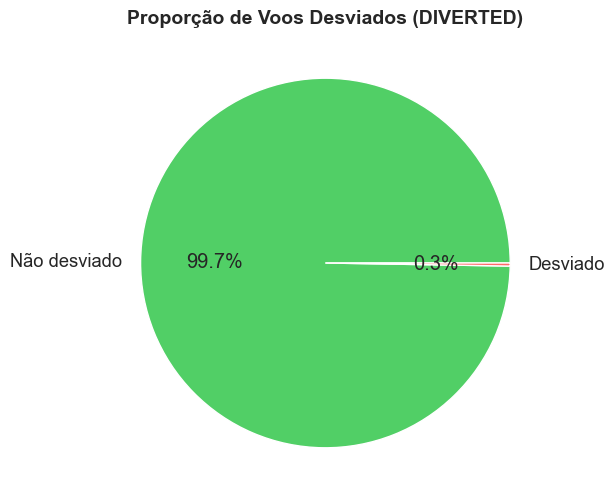

In [29]:
diverted_counts = flights_df['DIVERTED'].value_counts()

plt.figure(figsize=(6, 6))
diverted_status_labels = ['Não desviado', 'Desviado'] # Certifique-se que a ordem corresponde aos dados
plt.pie(diverted_counts, labels=diverted_status_labels, autopct='%1.1f%%', colors=['#51cf66', '#ff6b6b'])
plt.title('Proporção de Voos Desviados (DIVERTED)', fontsize=14, weight='bold')
plt.show()

In [30]:
time_cols = [c for c in flights_df.columns if c.endswith("TIME")]

# Para cada uma, verificar a proporção de nulos com base em DIVERTED
for col in time_cols:
    summary = (
        flights_df.groupby(["DIVERTED"])[col]
        .apply(lambda x: x.isna().mean() * 100)
        .reset_index(name="%_missing")
        .sort_values("%_missing", ascending=False)
    )
    print(f"\nPadrões de ausência para {col}:")
    display(summary)


Padrões de ausência para DEPARTURE_TIME:


,DIVERTED,%_missing
0,0,0.0
1,1,0.0



Padrões de ausência para SCHEDULED_TIME:


,DIVERTED,%_missing
1,1,0.006585
0,0,0.000000



Padrões de ausência para ELAPSED_TIME:


,DIVERTED,%_missing
1,1,100.0
0,0,0.0



Padrões de ausência para AIR_TIME:


,DIVERTED,%_missing
1,1,100.0
0,0,0.0



Padrões de ausência para ARRIVAL_TIME:


,DIVERTED,%_missing
1,1,17.310858
0,0,0.000000


A coluna DEPARTURE_TIME está 100% preenchida, então sabemos que todos os voos decolaram. Eles não têm ARRIVAL_TIME em ~17% dos casos, mas provavelmente não são os mesmos voos desviados que já identificamos. A hipótese mais forte é que esses são voos que retornaram ao aeroporto de origem.

Essa hipótese pode ser verificada se, para esses voos, o aeroporto de origem é o mesmo que o de destino (o que seria impossível em um voo normal) ou, se eles possuem tempo de voo (AIR_TIME) mas não dados de chegada (WHEELS_ON, TAXI_IN). Como AIR_TIME tem mais nulos, vamos usar uma abordagem diferente: verificar se a soma dos tempos de voo conhecidos não faz sentido.

In [31]:
null_arrival_time = flights_df[flights_df['ARRIVAL_TIME'].isnull()]
non_diverted_null_arrival = null_arrival_time[null_arrival_time['DIVERTED'] == 0]

print(f"Número de voos com ARRIVAL_TIME nulo e que não são 'DIVERTED': {len(non_diverted_null_arrival)}")


Número de voos com ARRIVAL_TIME nulo e que não são 'DIVERTED': 0


O resultado 0 indica que se não há voos com ARRIVAL_TIME nulo que não sejam desviados, isso significa que TODOS os voos com dados de chegada faltando (ARRIVAL_TIME, WHEELS_ON, etc.) são, na verdade, um subconjunto dos voos desviados. Isso apenas reforça a nossa conclusão anterior, mas com mais certeza: a única causa para dados de tempo de chegada ausentes neste dataset é o fato de o voo ter sido desviado (DIVERTED == 1). 

Portanto, fica como ação para ser feita sobre os dados a remoção de todos os registros onde 'DIVERTED = 1'. Vamos, então, confirmar essa conclusão.

In [32]:
display(time_null_summary)

,n_missing,pct_missing
DEPARTURE_TIME,0,0.00
SCHEDULED_TIME,1,0.00
ELAPSED_TIME,15187,0.27
AIR_TIME,15187,0.27
ARRIVAL_TIME,2629,0.05


In [33]:
temp_df = flights_df.copy()
rows_before = len(temp_df)

temp_df = temp_df[temp_df['DIVERTED'] == 0]
rows_after = len(temp_df)

print(f"{rows_before - rows_after} linhas removidas")

temp_df = temp_df.drop(columns=['DIVERTED'])
print("Coluna 'DIVERTED' removida.")
flights_df = temp_df
flights_df.info(show_counts=True)


15187 linhas removidas
Coluna 'DIVERTED' removida.
<class 'pandas.core.frame.DataFrame'>
Index: 5714008 entries, 0 to 5819078
Data columns (total 28 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5714008 non-null  int64  
 1   MONTH                5714008 non-null  int64  
 2   DAY                  5714008 non-null  int64  
 3   DAY_OF_WEEK          5714008 non-null  int64  
 4   AIRLINE              5714008 non-null  object 
 5   FLIGHT_NUMBER        5714008 non-null  int64  
 6   TAIL_NUMBER          5714008 non-null  object 
 7   ORIGIN_AIRPORT       5714008 non-null  object 
 8   DESTINATION_AIRPORT  5714008 non-null  object 
 9   SCHEDULED_DEPARTURE  5714008 non-null  int64  
 10  DEPARTURE_TIME       5714008 non-null  float64
 11  DEPARTURE_DELAY      5714008 non-null  float64
 12  TAXI_OUT             5714008 non-null  float64
 13  WHEELS_OFF           5714008 non-null  float64
 14  SCHE

Agora vamos verificar se a coluna ELAPSED_TIME possui inconsistências.

In [34]:
flights_df['CALCULATED_ELAPSED_TIME'] = flights_df['TAXI_OUT'] + flights_df['AIR_TIME'] + flights_df['TAXI_IN']
flights_df['TIME_DIFFERENCE'] = flights_df['ELAPSED_TIME'] - flights_df['CALCULATED_ELAPSED_TIME']

inconsistent_flights = flights_df[flights_df['TIME_DIFFERENCE'] != 0]
count_inconsistent = len(inconsistent_flights)
total_flights = len(flights_df)

print(f"Total de voos analisados: {total_flights}")
print(f"Número de voos com tempo inconsistente: {count_inconsistent}")

if count_inconsistent > 0:
    print(inconsistent_flights['TIME_DIFFERENCE'].describe())


Total de voos analisados: 5714008
Número de voos com tempo inconsistente: 0


### Cardinalidade e duplicatas

In [39]:
# Duplicatas
dup_complete = flights_df.duplicated().sum()
print(f"Duplicatas completas: {dup_complete:,}")

Duplicatas completas: 0


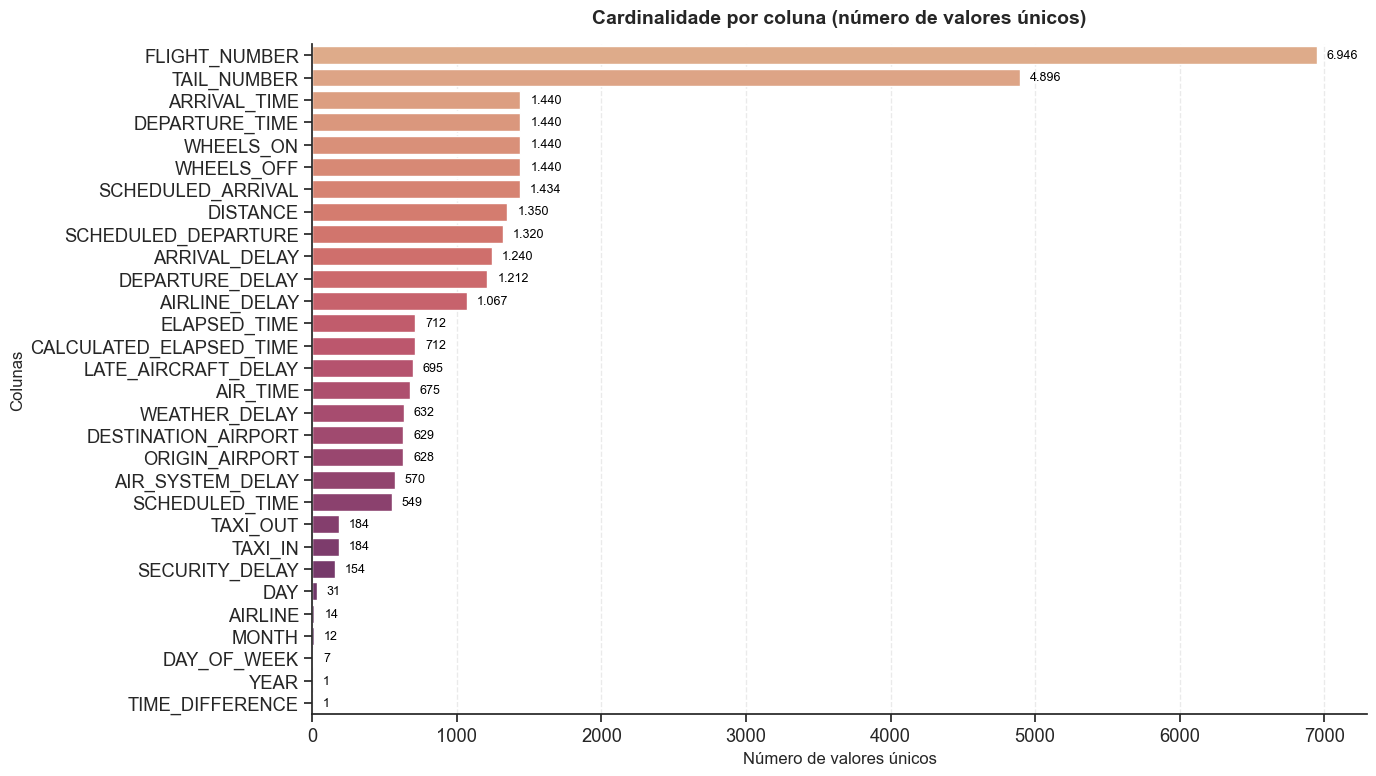

In [37]:
# Gráfico de duplicatas
cardinality = flights_df.nunique().sort_values(ascending=False).reset_index()
cardinality.columns = ["coluna", "n_valores_unicos"]

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=cardinality,
    x="n_valores_unicos",
    y="coluna",
    hue="coluna",
    palette="flare",
    orient="h",
    legend=False
)

for i, v in enumerate(cardinality["n_valores_unicos"]):
    ax.text(
        v + (0.01 * cardinality["n_valores_unicos"].max()),
        i,
        f"{v:,}".replace(",", "."),
        va="center",
        fontsize=9,
        color="black"
    )

ax.set_title("Cardinalidade por coluna (número de valores únicos)", fontsize=14, weight="bold", pad=15)
ax.set_xlabel("Número de valores únicos", fontsize=12)
ax.set_ylabel("Colunas", fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Verificando duplicatas naturais

In [39]:
key_cols = ["YEAR","MONTH","DAY","FLIGHT_NUMBER","AIRLINE"]
dup_counts = flights_df.groupby(key_cols).size().reset_index(name="count")
multi_keys = dup_counts[dup_counts['count'] > 1]

print(f"Chaves naturais com múltiplos registros: {len(multi_keys):,}")

subset = flights_df.merge(multi_keys[key_cols], on=key_cols, how="inner")
all_identical = (subset.groupby(key_cols).nunique(dropna=False) == 1).all(axis=1).all()
print(f"Todos os registros são idênticos? {all_identical}")


Chaves naturais com múltiplos registros: 1,276,904
Todos os registros são idênticos? False


Pegando 5 chaves naturais para inspeção

In [41]:
multi_keys = flights_df.groupby(key_cols).size().reset_index(name="count").query("count>1").sort_values("count", ascending=False).head(5)
multi_keys

if not multi_keys.empty:
    example = multi_keys.iloc[0][key_cols].to_dict()
    mask = pd.concat([flights_df[c] == example[c] for c in key_cols], axis=1).all(axis=1)
    display(flights_df.loc[mask].sort_values(["ORIGIN_AIRPORT","SCHEDULED_DEPARTURE"]))
else:
    print("Nenhuma chave natural com repetições encontrada.")


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,CALCULATED_ELAPSED_TIME,TIME_DIFFERENCE
1597926,2015,4,13,1,WN,4550,N397SW,DTW,MDW,650,...,700,836.0,96.0,96.0,0.0,0.0,0.0,0.0,83.0,0.0
1601059,2015,4,13,1,WN,4550,N775SW,MCI,STL,945,...,1040,1042.0,2.0,NaN,NaN,NaN,NaN,NaN,51.0,0.0
1608102,2015,4,13,1,WN,4550,N775SW,MCO,SAT,1645,...,1835,1902.0,27.0,0.0,0.0,7.0,20.0,0.0,161.0,0.0
1598906,2015,4,13,1,WN,4550,N775SW,MDW,MCI,735,...,900,918.0,18.0,1.0,0.0,0.0,17.0,0.0,86.0,0.0
1604851,2015,4,13,1,WN,4550,N775SW,MSY,MCO,1330,...,1610,1636.0,26.0,26.0,0.0,0.0,0.0,0.0,121.0,0.0
1611936,2015,4,13,1,WN,4550,N775SW,SAN,PHX,2040,...,2150,2141.0,-9.0,NaN,NaN,NaN,NaN,NaN,64.0,0.0
1610591,2015,4,13,1,WN,4550,N775SW,SAT,SAN,1910,...,2005,2016.0,11.0,NaN,NaN,NaN,NaN,NaN,160.0,0.0
1602586,2015,4,13,1,WN,4550,N775SW,STL,MSY,1110,...,1255,1302.0,7.0,NaN,NaN,NaN,NaN,NaN,98.0,0.0


Observando as duplicatas naturais, percebe-se que o motivo de está duplicado é porque as tuplas representam voos de escalas, que apesar de terem o mesmo número de voos são viagens diferentes.

### Verificação de tipos e inconsistências

Alguns tipos de dados devem ser modificados, nas colunas de tempos o formato não está ideal para a visualização (valor inteiro, ex: 0000) o ideal seria datetime. As colunas contendo datas devem ser agregadas em uma única coluna. Outras inconsistências já foram verificadas. Vamos checar se existe NaN's em colunas que não deveria ter.

In [42]:
core_columns = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_TIME', 'TAIL_NUMBER', 'AIRLINE']
print("\nVerificando nulos em colunas essenciais:")
print(flights_df[core_columns].isnull().sum())

flights_df.dropna(subset=core_columns, inplace=True)



Verificando nulos em colunas essenciais:
DEPARTURE_DELAY    0
ARRIVAL_DELAY      0
AIR_TIME           0
TAIL_NUMBER        0
AIRLINE            0
dtype: int64


Os resultados mostra que não ocorre mais nulos. Vamos verificar para as colunas de atrasos:

In [46]:
reason_columns = ['AIRLINE_DELAY', 'WEATHER_DELAY', 'LATE_AIRCRAFT_DELAY', 
                  'AIR_SYSTEM_DELAY', 'SECURITY_DELAY']

print("Verificando nulos nas colunas de motivo de atraso:\n")
print(flights_df[reason_columns].isnull().sum())

flights_df[reason_columns] = flights_df[reason_columns].fillna(0)
print("\nNulos após tratamento:", flights_df[reason_columns].isnull().sum().sum())


Verificando nulos nas colunas de motivo de atraso:

AIRLINE_DELAY          0
WEATHER_DELAY          0
LATE_AIRCRAFT_DELAY    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
dtype: int64

Nulos após tratamento: 0


In [ ]:
cols_delay = [
    ("DEPARTURE_DELAY", "AIRLINE_DELAY"),
    ("ARRIVAL_DELAY", "AIRLINE_DELAY"),
    ("DEPARTURE_DELAY", "ARRIVAL_DELAY")
]

# Estilo visual
sns.set(style="whitegrid", palette="muted")

sample_df = flights_df.sample(5000)

# Tamanho do grid
fig, axes = plt.subplots(1, len(cols_delay), figsize=(18, 6))

for i, (x_col, y_col) in enumerate(cols_delay):
    ax = axes[i]
    sns.regplot(
        data=flights_df,
        x=x_col,
        y=y_col,
        ax=ax,
        scatter_kws={'alpha': 0.5, 's': 20},
        line_kws={'color': 'red', 'label': 'Linha de Regressão'}
    )
    ax.set_title(f'{y_col} vs {x_col}', fontsize=13, fontweight='bold')
    ax.set_xlabel(x_col, fontsize=11)
    ax.set_ylabel(y_col, fontsize=11)
    ax.legend()

plt.tight_layout()
plt.show()


## Plano de Ação - Diretrizes para a camada Silver

**Airline**
  - Realizar as conversões de tipos dos atributos;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRLINE_IATA_CODE*;
  - Alterar o nome da coluna AIRLINE: *AIRLINE* -> *AIRLINE_NAME*;
  - Tornar a coluna AIRLINE_IATA_CODE 'primary key'.

**Airports**
  - Realizar as conversões de tipos dos atributos;
  - Alterar o nome da coluna IATA_CODE: *IATA_CODE* -> *AIRPORT_IATA_CODE*;
  - Tornar a coluna AIRPORT_IATA_CODE 'primary key'.
  - Remover coluna COUNTRY;
  - LATITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST;
  - LONGITUDE adicionar valores reais para as tuplas com IATA_CODE = ECP, PBG e UST.

**Flights**
  - Realizar as conversões de tipos: (**Ex: `DEPARTURE_DELAY`: double, `DISTANCE`: double);
  - Adicionar nova coluna `FLIGHT_ID` para ser primary key (**gerada a partir de um hash de colunas de identificação**);
  - Agregar as colunas `YEAR`, `MONTH`, `DAY` em uma única coluna `FLIGHT_DATE` (**tipo Date**);
  - Altera as colunas de tempo para o formato datetime, atualmente os dois primeiros dígitos são as horas e os dois últimos os minutos;
  - Filtrar e remover todos os registros onde `DIVERTED == 1`;
  - REmover as colunas `DIVERTED`, `CANCELLED`, `CANCELLATION_REASON`, `YEAR`, `MONTH` e `DAY`;
  - Preencher valores nulos com `0` nas colunas `AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY` e `WEATHER_DELAY`;
  - Implementar verificação de qualidade: Validar a cada execução se ELAPSED_TIME corresponde à soma de suas partes (TAXI_OUT + AIR_TIME + TAXI_IN). A pipeline deve falhar caso alguma inconsistência seja detectada em cargas de dados futuras.

**Testes de Qualidade (Quality Gates)**
  - Verificar a qunatidade de dados nas colnuas para certificar que não ocorreu nenhum erro no processamento;
  - Validar se ELAPSED_TIME corresponde à soma de TAXI_OUT + AIR_TIME + TAXI_IN;
  - Validar se DEPARTURE_TIME_TS é anterior a ARRIVAL_TIME_TS;
  - Validar se todos os AIRLINE_IATA_CODE da tabela Flights existem na tabela Airlines;
  - Validar se todos os ORIGIN_AIRPORT e DESTINATION_AIRPORT existem na tabela Airports;
  - Validar se ORIGIN_AIRPORT é diferente de DESTINATION_AIRPORT;
  - Validar se DISTANCE é sempre um valor positivo (> 0);
  - Validar a consistência dos motivos de atraso: Se ARRIVAL_DELAY > 0, a soma dos motivos do atraso deve ser próxima ao valor de ARRIVAL_DELAY.

In [3]:
cols = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'WHEELS_OFF', 'WHEELS_ON']

display(flights_df.head()[cols])

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,WHEELS_OFF,WHEELS_ON
0,5,2354.0,430,408.0,15.0,404.0
1,10,2.0,750,741.0,14.0,737.0
2,20,18.0,806,811.0,34.0,800.0
3,20,15.0,805,756.0,30.0,748.0
4,25,24.0,320,259.0,35.0,254.0
